In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from data_generator import DataGenerator

2025-07-17 18:46:06.005866: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-17 18:46:07.219399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-17 18:46:07.219479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-17 18:46:07.363599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-17 18:46:07.671582: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Import the train and validation input and target data

In [3]:
X_train = np.load("data/Overlapping_data/Train_features_and_targets/all_train_features.npy")
train_targets = np.load("data/Stage2_base_model/Overlapping/train_targets/all_train_targets.npy")

In [4]:
X_train.shape

(49152, 13, 32, 32, 3)

In [5]:
train_targets.shape

(49152, 7)

In [6]:
# we need the train data in the shape (49152, 7, 1) - let's reshape this

In [7]:
y_train = train_targets.reshape(49152, 7, 1)

In [8]:
y_train.shape

(49152, 7, 1)

In [9]:
# Load the validation data
X_valid = np.load("data/Overlapping_data/Valid_features_and_targets/all_valid_features.npy")
valid_targets = np.load("data/Stage2_base_model/Overlapping/valid_targets/all_valid_targets.npy")

In [10]:
X_valid.shape, valid_targets.shape

((12288, 13, 32, 32, 3), (12288, 7))

In [11]:
# reshape validation target

In [12]:
y_valid = valid_targets.reshape(12288, 7, 1)

In [13]:
y_valid.shape

(12288, 7, 1)

In [14]:
# let's load and define the model below
CNN_model = tf.keras.models.load_model('../../Spring_2024/Bayes_for_comps/TS_bayes_implementation_for_TN/models/trained_gmp_model_dense_32_new.h5')

2025-07-17 18:48:13.987364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:06:00.0, compute capability: 7.0


In [15]:
CNN_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 activation_1 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                           

In [16]:
# Define this reduced model

output_reduced = CNN_model.layers[-11].output

In [17]:
reduced_model = tf.keras.models.Model(inputs = CNN_model.input, outputs = output_reduced)

In [18]:
reduced_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 activation_1 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                             

In [19]:
# okay, now need to add back the dropout, the dense and activation

# add dropout
added_dropout = tf.keras.layers.Dropout(0.5, name = "New_dropout_0")(CNN_model.layers[-11].output)

# add global max pooling
added_flatten = tf.keras.layers.GlobalMaxPooling2D()(added_dropout)

# add dense
added_dense = tf.keras.layers.Dense(64, name = "New_Dense_0")(added_flatten)

# add activation
added_Act = tf.keras.layers.Activation('relu', name = "New_Activation_0")(added_dense)

# add dropout
added_dropout2 = tf.keras.layers.Dropout(0.5, name = "New_dropout_1")(added_Act)

# # add another dense
added_dense_1 = tf.keras.layers.Dense(32, name = "New_Dense_1")(added_dropout2)

# # add activation
added_Act_1 = tf.keras.layers.Activation('relu', name = "New_Activation_1")(added_dense_1)

new_model = tf.keras.models.Model(CNN_model.input, added_Act_1)

In [20]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 activation_1 (Activation)   (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 32)    0         
 D)                                                              
                                                           

In [21]:
36928 + 4160 + 2080

43168

In [22]:
# Okay, now define our model
input_time = 13
output_time = 7
feature_size = 1
# Encoder part

# input
Encoder_input = tf.keras.layers.Input(shape = [input_time, None, None, 3])

# pass model through TD layer
TD_model = tf.keras.layers.TimeDistributed(new_model)

TD_out = TD_model(Encoder_input)

# pass this through a sequence model to adress the sequential nature of the input image sequence
lstm_layer = tf.keras.layers.LSTM(64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = False, return_state = True)

lstm_out, state_h, state_c = lstm_layer(TD_out)

# Decoder part

# repeat the context vector
decoder_inp = tf.keras.layers.RepeatVector(output_time)(lstm_out)

# Add an LSTM layer for the decoder
decoder_LSTM = tf.keras.layers.LSTM(64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True, return_state = False)

lstm_out = decoder_LSTM(decoder_inp, initial_state = [state_h, state_c])

# add a dense layer to get the targets
dense_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(feature_size, activation = 'relu'))

pred_head = dense_layer(lstm_out)

In [23]:
base_model = tf.keras.models.Model(inputs = Encoder_input, outputs = pred_head)

In [24]:
base_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, None, None, 3)   0         []                            
                             ]                                                                    
                                                                                                  
 time_distributed (TimeDist  (None, 13, 32)               71808     ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 lstm (LSTM)                 [(None, 64),                 24832     ['time_distributed[0][0]']    
                              (None, 64),                                                   

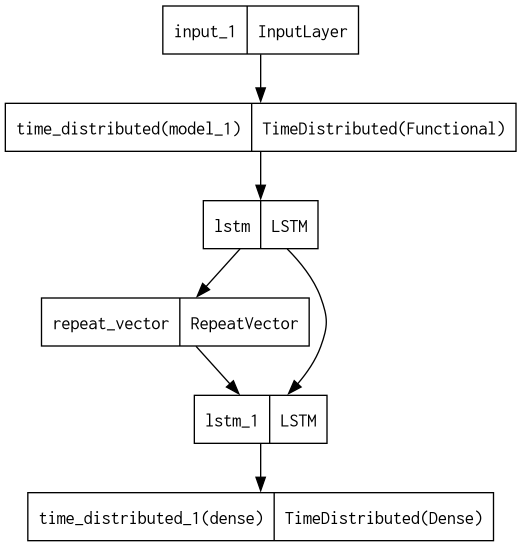

In [25]:
tf.keras.utils.plot_model(base_model)

In [26]:
# Need to also take care of freezing and unfreezing weights during model training

In [27]:
# freeze the layers
for layer in CNN_model.layers:
    layer.trainable = False

In [28]:
base_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, None, None, 3)   0         []                            
                             ]                                                                    
                                                                                                  
 time_distributed (TimeDist  (None, 13, 32)               71808     ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 lstm (LSTM)                 [(None, 64),                 24832     ['time_distributed[0][0]']    
                              (None, 64),                                                   

In [29]:
# Let's run this model with a generator?

# Else eveything would be stored in the memory, and we will run into issues

In [30]:
%%time
batch_size = 64
generator_batch_size = 64
train_gen = DataGenerator(X_train, y_train, batch_size, shuffle=False)
val_gen = DataGenerator(X_valid, y_valid, batch_size, shuffle=False)

CPU times: user 0 ns, sys: 823 µs, total: 823 µs
Wall time: 757 µs


In [31]:
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
train_steps = int(np.ceil(len(X_train) / generator_batch_size))
validation_steps = int(np.ceil(len(X_valid) / generator_batch_size))

In [32]:
%%time

# Since the training is taking too much time and we would like to figure out the inference part, let's have the patience at 2 and run it just for 10 epochs
# compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
base_model.compile(loss='mean_squared_error', optimizer=opt, metrics = ['mean_absolute_error'])
    
# add early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, verbose=1, patience=20)

# fit the generator - the steps are a must here
history = base_model.fit(train_gen,
          validation_data = val_gen, steps_per_epoch=steps_per_epoch, 
                                  validation_steps=validation_steps,           
          epochs = 100, callbacks = [es])

Epoch 1/100


2025-07-17 18:48:21.447634: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/time_distributed/model_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-07-17 18:48:22.511598: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-07-17 18:48:25.904213: I external/local_xla/xla/service/service.cc:168] XLA service 0x150874858b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-17 18:48:25.904253: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2025-07-17 18:48:25.914555: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752796106.056220  965563 device_compiler.h:186] Compi

768/768 [==============================] - 59s 65ms/step - loss: 0.0278 - mean_absolute_error: 0.0685 - val_loss: 0.0153 - val_mean_absolute_error: 0.0321
Epoch 2/100
768/768 [==============================] - 50s 65ms/step - loss: 0.0267 - mean_absolute_error: 0.0674 - val_loss: 0.0151 - val_mean_absolute_error: 0.0333
Epoch 3/100
768/768 [==============================] - 50s 65ms/step - loss: 0.0263 - mean_absolute_error: 0.0671 - val_loss: 0.0149 - val_mean_absolute_error: 0.0361
Epoch 4/100
768/768 [==============================] - 50s 64ms/step - loss: 0.0261 - mean_absolute_error: 0.0673 - val_loss: 0.0148 - val_mean_absolute_error: 0.0388
Epoch 5/100
768/768 [==============================] - 50s 65ms/step - loss: 0.0260 - mean_absolute_error: 0.0672 - val_loss: 0.0149 - val_mean_absolute_error: 0.0452
Epoch 6/100
768/768 [==============================] - 50s 65ms/step - loss: 0.0259 - mean_absolute_error: 0.0676 - val_loss: 0.0147 - val_mean_absolute_error: 0.0374
Epoch 7/10

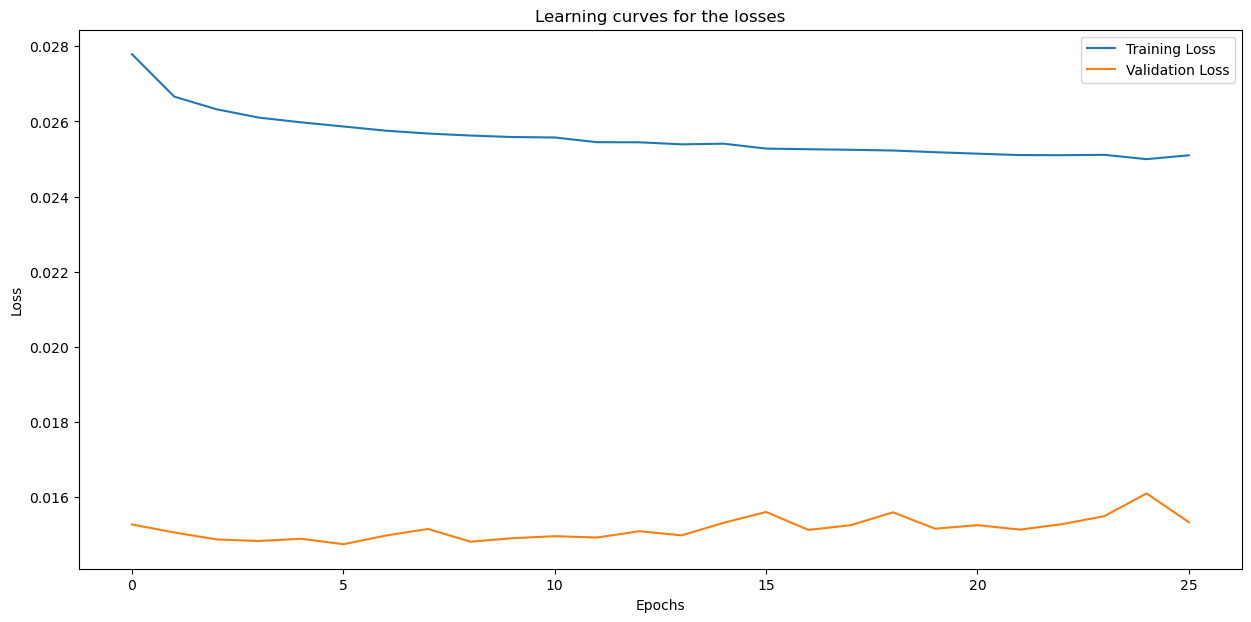

In [33]:
# plot the losses
plt.figure(figsize = (15,7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Learning curves for the losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# history.history['loss']

In [34]:
# Now unfreeze the last CNN layer
CNN_model.trainable = True

set_trainable = False

for layer in CNN_model.layers:
    if layer.name == 'conv2d_3':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [35]:
base_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13, None, None, 3)   0         []                            
                             ]                                                                    
                                                                                                  
 time_distributed (TimeDist  (None, 13, 32)               71808     ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 lstm (LSTM)                 [(None, 64),                 24832     ['time_distributed[0][0]']    
                              (None, 64),                                                   

In [36]:
%%time

# compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
base_model.compile(loss='mean_squared_error', optimizer=opt, metrics = ['mean_absolute_error'])
    
# add early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, verbose=1, patience=20)

# fit the generator - the steps are a must here
history_new = base_model.fit(train_gen,
          validation_data = val_gen, steps_per_epoch=steps_per_epoch, 
                                  validation_steps=validation_steps,           
          epochs = 100, callbacks = [es])

Epoch 1/100


2025-07-17 19:09:56.246840: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/time_distributed/model_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


768/768 [==============================] - 56s 66ms/step - loss: 0.0258 - mean_absolute_error: 0.0670 - val_loss: 0.0149 - val_mean_absolute_error: 0.0463
Epoch 2/100
768/768 [==============================] - 50s 66ms/step - loss: 0.0257 - mean_absolute_error: 0.0673 - val_loss: 0.0148 - val_mean_absolute_error: 0.0476
Epoch 3/100
768/768 [==============================] - 51s 66ms/step - loss: 0.0255 - mean_absolute_error: 0.0668 - val_loss: 0.0148 - val_mean_absolute_error: 0.0454
Epoch 4/100
768/768 [==============================] - 51s 66ms/step - loss: 0.0254 - mean_absolute_error: 0.0664 - val_loss: 0.0148 - val_mean_absolute_error: 0.0509
Epoch 5/100
768/768 [==============================] - 50s 66ms/step - loss: 0.0253 - mean_absolute_error: 0.0664 - val_loss: 0.0150 - val_mean_absolute_error: 0.0562
Epoch 6/100
768/768 [==============================] - 50s 66ms/step - loss: 0.0253 - mean_absolute_error: 0.0661 - val_loss: 0.0148 - val_mean_absolute_error: 0.0496
Epoch 7/10

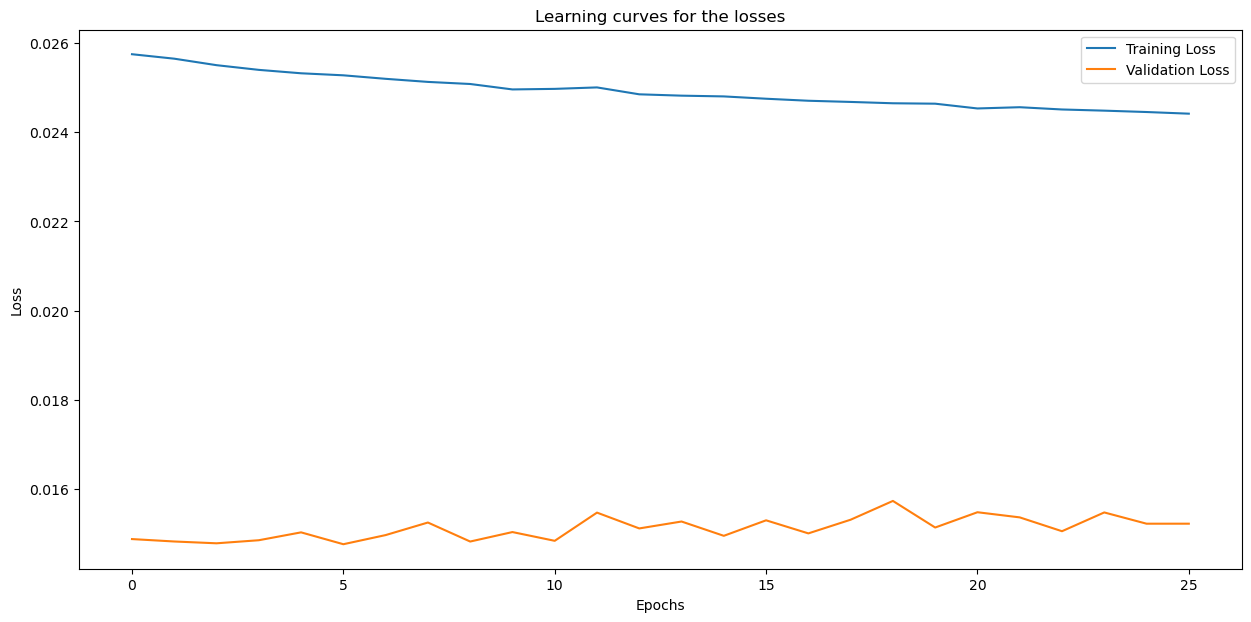

In [37]:
# plot the losses
plt.figure(figsize = (15,7))
plt.plot(history_new.history['loss'], label='Training Loss')
plt.plot(history_new.history['val_loss'], label='Validation Loss')
plt.title("Learning curves for the losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# history.history['loss']

In [38]:
# save the train model
# save this model
model_name_finetuned = 'stage2_base_model_overlapping.keras'
base_model.save('models' + '/' + model_name_finetuned)